In [ ]:
import dill
dill.load_session('Data/MOD09.db')

In [ ]:
https://github.com/MarcLefevreFr/OpenClassrooms

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost
import sklearn
import marko
#import shap
from time import time
from feat_positive_construction import auto_search
from category_encoders.target_encoder import TargetEncoder

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, Normalizer, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
#from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_log_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, RandomizedSearchCV, cross_val_predict
#from sklearn.decomposition import PCA
#from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import RFECV
from itertools import combinations

pd.options.display.max_columns = 60

# Présentation : Mission et Démarche

In [ ]:
Nous allons tester différents modèles (...)

In [ ]:
- choix des modèles

In [ ]:
- choix des métriques

In [ ]:
- descrip du processus, présentations, CV, ESS, méthode pipeline ou pas, encodage, etc..

# 1 - Première approche

## A) Etapes Préliminaires

Définition de constantes

In [2]:
# liste des colonnes de nos df de présentations des résultats
LISTE_COL = ["Model", "Fit_Time", "Score_time", "MAE", "RMSLE", "R2"] 

# Métriques utilisées en temps normal et au cas ou la MSLE ne soit pas adaptée
SCORING = ["neg_mean_absolute_error", "neg_mean_squared_log_error", "r2"]
SCORING_alt = ["neg_mean_absolute_error", "r2"]

# facteur aléatoire que nous utiliserons le long de notre travail
SEED = 47

# nombre de "folds" lors des validation croisées
K = 5

Définition de notre **panel initial d'estimateurs** dans un dictionnaire.

In [3]:
d_mod = {"Linear_Reg" : LinearRegression(),
        "Ridge_Reg" : Ridge(),
        "Lasso_Reg" : Lasso(),
        "SGD_Reg" : SGDRegressor(),
        "SV_Reg" : SVR(),
        "DT_Reg" : DecisionTreeRegressor(),
        "RF_Reg" : RandomForestRegressor(),
        "Adaboost_Reg" : AdaBoostRegressor(),
        "Bagging_Reg" : BaggingRegressor(base_estimator = DecisionTreeRegressor()),
        "GB_Reg" : GradientBoostingRegressor(),
        "XGB_Reg" : xgboost.XGBRegressor(random_state = SEED)
       }

Définition de notre fonction de **modélisation**

In [4]:
def modelize(model, name, X, y, return_model = False , graph = False, k = K) :
        
    resultats = []
    
    kf = KFold(k, shuffle = True, random_state = SEED)
    
    try :
        cv_res = cross_validate(model, X, y, scoring = SCORING, cv = kf)

        resultats.append(name)
        resultats.append(cv_res["fit_time"].sum())
        resultats.append(cv_res["score_time"].sum())
        resultats.append(-cv_res['test_neg_mean_absolute_error'].mean())
        resultats.append(np.sqrt(-cv_res['test_neg_mean_squared_log_error'].mean()))
        resultats.append(cv_res['test_r2'].mean())

    
    # Si, comme cela arrive parfois, la RMSLE est impossible à calculer, on lui donne la valeur 0.
    except :
        
        cv_res = cross_validate(model, X, y, scoring = SCORING_alt, cv = kf)
        
        resultats.append(name)
        resultats.append(cv_res["fit_time"].sum())
        resultats.append(cv_res["score_time"].sum())
        resultats.append(-cv_res['test_neg_mean_absolute_error'].mean())
        resultats.append(0)  
        resultats.append(cv_res['test_r2'].mean())
    
    # affichage de graphs au choix
    if graph :

        pred = cross_val_predict(model, X, y, cv = kf)

        error = np.abs(y - pred)

        fig = plt.figure(figsize = (8, 8))
        plt.subplot(2,2,1)
        plt.scatter(y, pred, color = "coral")
        plt.subplot(2,2,2)
        plt.hist(error, bins = 50)
        plt.show()
            
    new_row = {k:v for k, v in zip(LISTE_COL, resultats)}

    # récupération d'un modèle entrainé au choix
    if return_model :
        
        return new_row, model.fit(X, y)
        
    else :        
    
        return new_row

Chargement des données

In [5]:
# chargement de nos données avec et sans outliers
X = pickle.load(open("Data/X.pickle", "rb"))
y = pickle.load(open("Data/y.pickle", "rb"))

X_no = pickle.load(open("Data/X_no.pickle", "rb"))
y_no = pickle.load(open("Data/y_no.pickle", "rb"))

# X sans EnergyStarScore
# X_ses = X.drop("ENERGYSTARScore", axis = 1)
# X_no_ses = X_no.drop("ENERGYSTARScore", axis = 1)

# num_feat = np.array(X.columns[X.dtypes != "category"])
# cat_feat = np.array(X.columns[X.dtypes == "category"])

# le premier modèle que nous créons est celui de SiteEnergyUse
y = y["SiteEnergyUseWN(kBtu)"]
y_no = y_no["SiteEnergyUseWN(kBtu)"]

# transformation log(p+1) de la cible
y = y.transform(np.log1p)
y_no = y_no.transform(np.log1p)

Définition de fonctions de **pre-processing**.

In [6]:

# Fonction d'imputation des valeurs manquantes de la variable ESS
# Ici on impute la valeur médiane aux valeurs manquante.

def num_imput(X):
    
    med = X["ENERGYSTARScore"].median()
    X["ENERGYSTARScore"] = X["ENERGYSTARScore"].fillna(med)
    
    return X



# Fonction appliquant les transformations de nos variables quantitatives.

def num_trans(X):
    
    num_feat = np.array(X.columns[X.dtypes != "category"])
     
    for col in num_feat :
        
        X[col] = X[col].transform(np.log1p) # transformation "log(p +1)"
        std = StandardScaler().fit(np.array(X[col]).reshape(-1,1)) # standardisation
        X[col] = std.transform(np.array(X[col]).reshape(-1,1))
        
    return X

# fonction d'encodage de nos variables catégorielles
# ici c'est du OneHotEncoding grâce à pd.get_dummies()
def cat_trans(X):
    
    cat_feat = np.array(X.columns[X.dtypes == "category"])
    X = pd.get_dummies(X, drop_first = True)
    #X = pd.get_dummies(X, drop_first = True)
    return X

# fonction de transformation globale regroupant les deux fonctions précédentes
def prepro(X):
    
    X = num_imput(X)
    X = num_trans(X)
    X = cat_trans(X)
    
    return X

## B) Modélisation OHE

In [7]:
# Preprocessing
X = prepro(X)

# Initialisation du DataFrame de résultats
df_res = pd.DataFrame(columns = LISTE_COL)

# Boucle de modélisation
for name, model in d_mod.items():
    
    df_res = df_res.append(modelize(model, name, X, y), ignore_index = True)
    
df_res

,Model,Fit_Time,Score_time,MAE,RMSLE,R2
0,Linear_Reg,0.167009,0.030002,0.338914,0.032626,0.808751
1,Ridge_Reg,0.561032,0.020002,0.331505,0.031820,0.818937
2,Lasso_Reg,0.065004,0.020001,0.892718,0.072079,-0.002240
3,SGD_Reg,0.435025,0.022001,0.416879,0.038833,0.720075
4,SV_Reg,5.384308,1.143065,0.315206,0.031889,0.814440
5,DT_Reg,0.251014,0.020001,0.456314,0.044542,0.640602
6,RF_Reg,12.719727,0.123007,0.336206,0.033584,0.796065
7,Adaboost_Reg,3.082176,0.090005,0.483489,0.042237,0.670268
8,Bagging_Reg,1.498086,0.062003,0.355902,0.035172,0.776205
9,GB_Reg,3.844220,0.028001,0.324678,0.031517,0.820577


**Commentaires**<br>Ces résultats constitue la base de travail que nous allons essayer d'améliorer.<br>Parmi eux, le résultat de la regression **lasso par défaut** nous pose question.

Clairement, on voit que la régression linéaire ne marche pas ici. Cette modélisation ne parvient pas à renvoyer autre chose qu'un résultat qui semble aberrant.

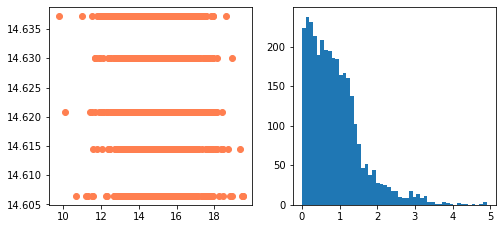

{'Model': 'XGB_Reg',
 'Fit_Time': 0.09700584411621094,
 'Score_time': 0.03400158882141113,
 'MAE': 0.892718476394694,
 'RMSLE': 0.07207918972987538,
 'R2': -0.0022402284744833523}

In [238]:
lasso = Lasso()
modelize(lasso, name, X, y, False, True)

Le graphe ci-dessous nous montre que chaque fold donne probablement des résultats bien hétérogènes. Regardons plus en détails les résultats...

In [239]:
cv_res = cross_validate(lasso, X, y, scoring = SCORING, 
                        cv = KFold(K, shuffle = True, random_state = SEED))

In [240]:
cv_res

{'fit_time': array([0.01900125, 0.02600145, 0.02000117, 0.01800084, 0.01800132]),
 'score_time': array([0.00800037, 0.00800061, 0.00600004, 0.00700045, 0.00600004]),
 'test_neg_mean_absolute_error': array([-0.92891721, -0.8869461 , -0.87290809, -0.87836227, -0.89645871]),
 'test_neg_mean_squared_log_error': array([-0.00562701, -0.00526098, -0.00487908, -0.00494031, -0.00526966]),
 'test_r2': array([-4.10120408e-03, -1.79092480e-05, -1.06028781e-03, -1.36437250e-03,
        -4.65736873e-03])}

In [241]:
cv_res['test_r2']

array([-4.10120408e-03, -1.79092480e-05, -1.06028781e-03, -1.36437250e-03,
       -4.65736873e-03])

Influence du paramètre **alpha**

In [206]:
X = pickle.load(open("Data/X.pickle", "rb"))
X = prepro(X)

error = []
lasso = Lasso()

alphas = np.linspace(0.01,10,50)

for l in alphas :
    lasso = Lasso(alpha = l)
    #lasso.set_params(alpha = l)
    cv_results = cross_validate(lasso, X, y, scoring = SCORING, cv = KFold(K, shuffle = True, random_state = SEED))
    print(cv_results)
    #coefs.append(lasso.coef_)
    error.append(-cv_results['test_neg_mean_absolute_error'].mean())

{'fit_time': array([0.01100063, 0.00900054, 0.01000071, 0.00800037, 0.01000071]), 'score_time': array([0., 0., 0., 0., 0.]), 'test_neg_mean_absolute_error': array([nan, nan, nan, nan, nan]), 'test_neg_mean_squared_log_error': array([nan, nan, nan, nan, nan]), 'test_r2': array([nan, nan, nan, nan, nan])}
{'fit_time': array([0.00800061, 0.00900054, 0.0090003 , 0.0090003 , 0.00800061]), 'score_time': array([0., 0., 0., 0., 0.]), 'test_neg_mean_absolute_error': array([nan, nan, nan, nan, nan]), 'test_neg_mean_squared_log_error': array([nan, nan, nan, nan, nan]), 'test_r2': array([nan, nan, nan, nan, nan])}
{'fit_time': array([0.00800061, 0.00900054, 0.00800061, 0.00800061, 0.0090003 ]), 'score_time': array([0., 0., 0., 0., 0.]), 'test_neg_mean_absolute_error': array([nan, nan, nan, nan, nan]), 'test_neg_mean_squared_log_error': array([nan, nan, nan, nan, nan]), 'test_r2': array([nan, nan, nan, nan, nan])}
{'fit_time': array([0.00900078, 0.00800061, 0.00800037, 0.0090003 , 0.00800061]), 'sc

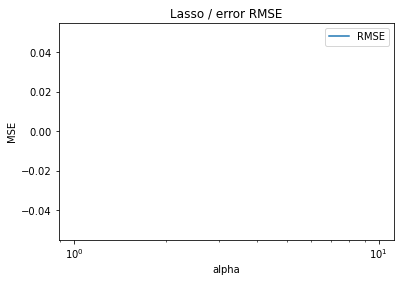

In [194]:
ax = plt.gca()

ax.plot(alphas, error)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Lasso / error RMSE')
#plt.axis('tight')
plt.legend(["RMSE"])
plt.show()

## C) Modélisation OHE sans Outliers ??????? On garde ou pas ???

In [244]:
# Init du DF de résultats
df_no = pd.DataFrame(columns = LISTE_COL)

# Preprocessing
X_no = prepro(X_no)

for name, model in d_mod.items():
    
    df_no = df_no.append(modelize(model, name, X_no, y_no), ignore_index = True)
    
df_no

,Model,Fit_Time,Score_time,MAE,RMSLE,R2
0,Linear_Reg,0.147008,0.021001,8.015078e+08,0,-2.986403e+20
1,Ridge_Reg,0.539031,0.024002,3.315077e-01,0.0320816,7.794114e-01
2,Lasso_Reg,0.078005,0.029002,8.158383e-01,0.0663413,-4.973718e-04
3,SGD_Reg,0.451025,0.024002,4.100089e-01,0.0390225,6.635389e-01
4,SV_Reg,5.066289,1.065061,3.105486e-01,0.0316448,7.844752e-01
5,DT_Reg,0.248014,0.023001,4.500970e-01,0.0444902,5.761362e-01
6,RF_Reg,12.624723,0.121007,3.341070e-01,0.0334661,7.582757e-01
7,Adaboost_Reg,3.146180,0.093005,4.669385e-01,0.041751,6.160580e-01
8,Bagging_Reg,1.468084,0.060004,3.504056e-01,0.0346837,7.391637e-01
9,GB_Reg,3.785216,0.027001,3.208255e-01,0.0312448,7.889874e-01


Un résultat un peu paradoxale. On aurait pu penser que sans une grande partie de leurs observations comportant des valeurs extrêmes, des données finalement plus homogènes auraient permi de meilleurs résultats. Or ceux-ci semblent clairement moins bons en plus d'apporter des résultats absurdes en RL et Lasso

## D) Discussion EnergyStarScore - épisode 1

Rappelons qu'au départ, cette variable contient une proportion notable de valeurs nulles.

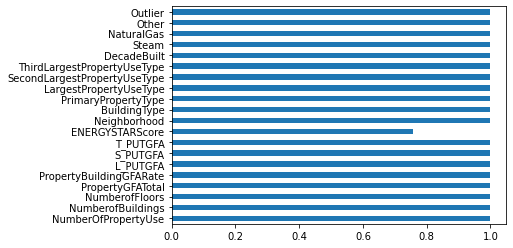

In [245]:
X_raw = pickle.load(open("Data/X.pickle", "rb"))
X_raw.notnull().mean().plot.barh()
plt.show()

En vue de nos modélisations avec elle, plutôt que de diminuer notre échantillon de données en nous séparant des observations dont sa valeur serait nulle, nous avions imputé sa valeur médiane à ses valeurs manquantes.

En utilisant trois estimateurs, **ridge**, **random forest**, et **gradient boosting**, nous allons d'abord regarder des indicateurs nous renseignant sur l'importance de cette variable.<br>Nous regarderons ensuite si se passer d'elle améliore ou détériore nos modélisations.

**Régression ridge**

In [249]:
# Rappel des résultats avec ESS
liste, mod = modelize(Ridge(), "regression ridge", X, y, True)
liste

{'Model': 'regression ridge',
 'Fit_Time': 0.5730326175689697,
 'Score_time': 0.02500152587890625,
 'MAE': 0.33150541011786283,
 'RMSLE': 0.03182039718066847,
 'R2': 0.8189374960278588}

Graph des coef ridge...

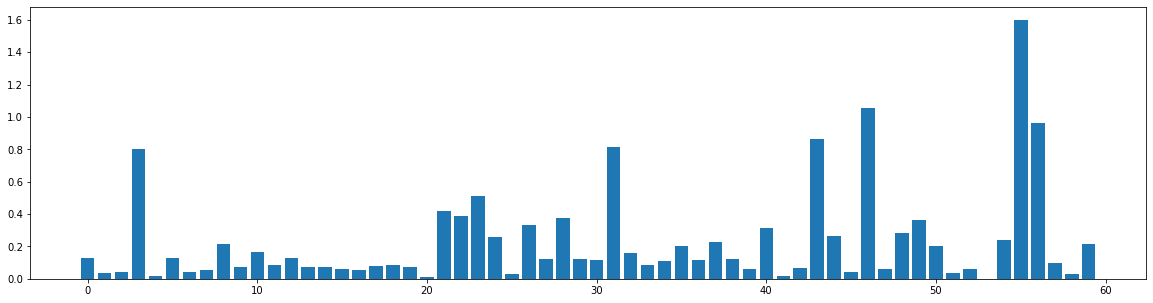

In [248]:
importance = pd.Series(mod.coef_, range(len(mod.coef_)))
fig = plt.figure(figsize = (20,5))
plt.bar(importance.index[:60], np.abs(importance.values)[:60])
plt.show()

In [250]:
X_ses = X.drop("ENERGYSTARScore", axis = 1)

In [253]:
# résultats sabs ESS
liste, mod = modelize(Ridge(), "regression ridge", X_ses, y, True)
liste

{'Model': 'regression ridge',
 'Fit_Time': 0.5760331153869629,
 'Score_time': 0.025001049041748047,
 'MAE': 0.3708046712120975,
 'RMSLE': 0.03454882484113154,
 'R2': 0.7853735420109278}

Les résultats sont sensiblement moins bons...

**Random forest**

In [254]:
liste, mod = modelize(RandomForestRegressor(), "random forest reg", X, y, True)
liste

{'Model': 'random forest reg',
 'Fit_Time': 13.564776420593262,
 'Score_time': 0.12200617790222168,
 'MAE': 0.33568821888847084,
 'RMSLE': 0.0336579852199894,
 'R2': 0.7952247291807172}

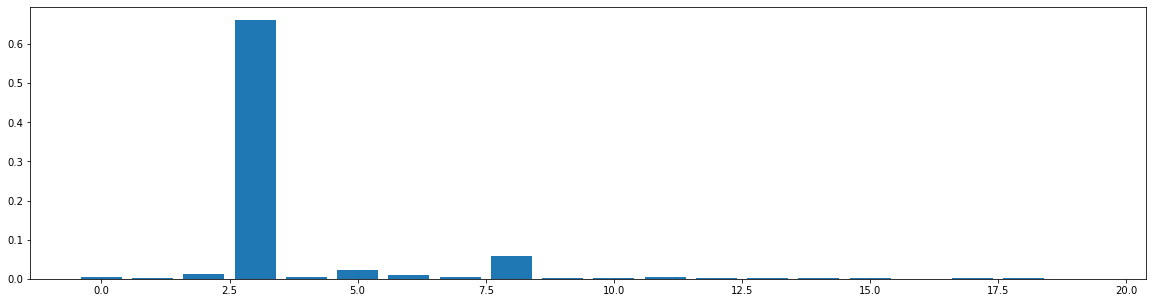

In [255]:
importance = pd.Series(mod.feature_importances_, 
                       range(len(mod.feature_importances_)))
fig = plt.figure(figsize = (20,5))
plt.bar(importance.index[:20], np.abs(importance.values)[:20])
plt.show()

In [256]:
mod.feature_importances_[8]

0.05838454251438692

Avec un estimateur RF, l'importance de l'ESS peut être quantifiée à **5,8 %**.

In [257]:
liste, mod = modelize(RandomForestRegressor(), "random forest reg", X_ses, y, True)
liste

{'Model': 'random forest reg',
 'Fit_Time': 13.464770078659058,
 'Score_time': 0.12500667572021484,
 'MAE': 0.3869594219944551,
 'RMSLE': 0.037192540351184786,
 'R2': 0.7501950477025048}

Là encore les résultats sont moins bons...

On regarde pour la régression **xgboost**

In [258]:
liste, mod = modelize(xgboost.XGBRegressor(random_state = SEED), "XGBoost", X, y, True)
liste

{'Model': 'XGBoost',
 'Fit_Time': 2.4411396980285645,
 'Score_time': 0.07000374794006348,
 'MAE': 0.31615174162161275,
 'RMSLE': 0.031345481562030805,
 'R2': 0.8236544069017133}

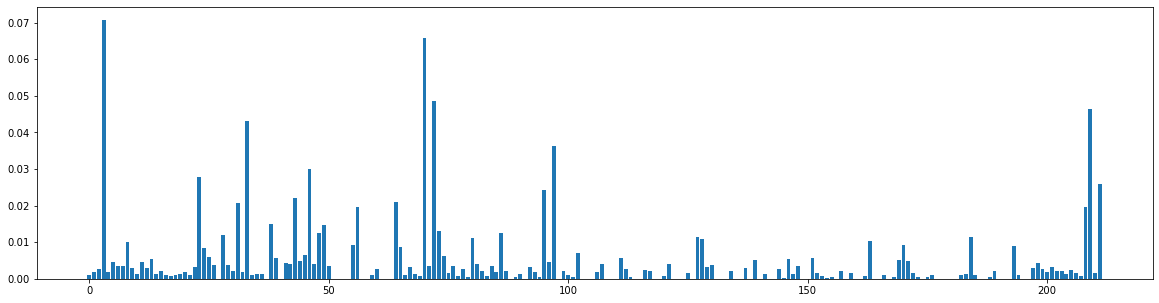

In [260]:
fig = plt.figure(figsize = (20,5))
plt.bar(range(len(mod.feature_importances_)), mod.feature_importances_)
plt.show()

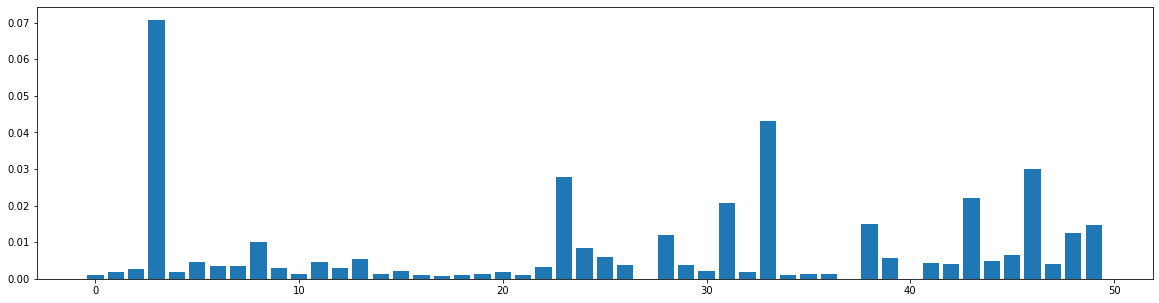

In [261]:
# zoom
fig = plt.figure(figsize = (20,5))
plt.bar(range(len(mod.feature_importances_[:50])), mod.feature_importances_[:50])
plt.show()

In [264]:
mod.feature_importances_[8]

0.01000348

Avec XGBoost, l'indicateur compte pour **1%**.

In [266]:
liste, mod = modelize(xgboost.XGBRegressor(random_state = SEED), "XGBoost", X_ses, y, True)
liste

{'Model': 'XGBoost',
 'Fit_Time': 2.511143445968628,
 'Score_time': 0.0760045051574707,
 'MAE': 0.3769052191009289,
 'RMSLE': 0.03569665242462174,
 'R2': 0.7712276082184132}

Ici aussi, se passer de la variable **EnergyStarScore** diminue la qualité de la modélisation.

## Modélisation avec Label Encoding

Ca devrait modifier les résultats de nos modèles linéaires mais peut-être améliorer les résultats des autres.

On va encoder nos données en amont du pipeline qui devra être aussi modifié...

In [8]:
X_lab = pickle.load(open("Data/X.pickle", "rb"))

X_lab = num_trans(X_lab)

cat_feat = np.array(X_lab.columns[X_lab.dtypes == "category"])

for cat in cat_feat :
    lab_enc = LabelEncoder()
    X_lab[cat] = lab_enc.fit_transform(X_lab[cat])

In [9]:
X_lab.head(3)

,NumberOfPropertyUse,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyBuildingGFARate,L_PUTGFA,S_PUTGFA,T_PUTGFA,ENERGYSTARScore,Neighborhood,BuildingType,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,DecadeBuilt,Steam,NaturalGas,Other,Outlier
0,0.405427,-0.149047,0.125401,-0.157012,0.350543,-0.282684,0.746611,-0.334138,0.355894,3,2,7,20,43,16,0,1,1,0,0
1,-0.851996,-0.149047,0.125401,-0.069383,0.350543,0.555618,-0.737749,-0.334138,0.525890,2,2,7,20,23,16,10,0,0,0,0
2,-0.851996,-0.149047,0.125401,0.818316,0.350543,-4.655013,-0.737749,-0.334138,0.618636,3,4,16,46,23,16,8,0,0,0,0


In [282]:
X_lab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3303 entries, 0 to 3339
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NumberOfPropertyUse           3303 non-null   float64
 1   NumberofBuildings             3303 non-null   float64
 2   NumberofFloors                3303 non-null   float64
 3   PropertyGFATotal              3303 non-null   float64
 4   PropertyBuildingGFARate       3303 non-null   float64
 5   L_PUTGFA                      3303 non-null   float64
 6   S_PUTGFA                      3303 non-null   float64
 7   T_PUTGFA                      3303 non-null   float64
 8   ENERGYSTARScore               2498 non-null   float64
 9   Neighborhood                  3303 non-null   int32  
 10  BuildingType                  3303 non-null   int32  
 11  PrimaryPropertyType           3303 non-null   int32  
 12  LargestPropertyUseType        3303 non-null   int32  
 13  Sec

In [11]:
df_res_lab = pd.DataFrame(columns = LISTE_COL)

for name, model in d_mod.items():
    
    try :
        cv_res = cross_validate(model, X, y, scoring = SCORING, cv = 5)
        print("OK")
        print(cv_res)
    except :
        cv_res = cross_validate(model, X, y, scoring = SCORING_alt, cv = 5)
        print("ALT")
        print(cv_res)

ALT
{'fit_time': array([0.02800155, 0.02800202, 0.03100181, 0.03100204, 0.02700138]), 'score_time': array([0.00400019, 0.00600004, 0.00500011, 0.00600028, 0.00400019]), 'test_neg_mean_absolute_error': array([-4.57514086e-01, -5.67223590e+07, -3.11493989e-01, -3.51334202e-01,
       -2.88305301e-01]), 'test_r2': array([ 7.43019998e-01, -1.49494617e+18,  7.76548041e-01,  6.38397702e-01,
        8.17431744e-01])}
OK
{'fit_time': array([0.11000633, 0.11100626, 0.1110065 , 0.11200643, 0.11500645]), 'score_time': array([0.00400019, 0.00500059, 0.00500011, 0.00400019, 0.00400019]), 'test_neg_mean_absolute_error': array([-0.4343818 , -0.32123148, -0.30269877, -0.3445679 , -0.28078756]), 'test_neg_mean_squared_log_error': array([-0.00128415, -0.00113736, -0.00079639, -0.0012411 , -0.00076067]), 'test_r2': array([0.76907148, 0.70987701, 0.79707252, 0.65478732, 0.82575057])}
OK
{'fit_time': array([0.01300049, 0.01300073, 0.01300073, 0.01300073, 0.01300049]), 'score_time': array([0.00400043, 0.005

In [12]:
df_res_lab = pd.DataFrame(columns = LISTE_COL)

for name, model in d_mod.items():
    
    df_res_lab = df_res_lab.append(modelize(model, name, X_lab, y), ignore_index = True)
    
df_res_lab

,Model,Fit_Time,Score_time,MAE,RMSLE,R2
0,Linear_Reg,0.018001,0.000000,NaN,NaN,NaN
1,Ridge_Reg,0.019001,0.000000,NaN,NaN,NaN
2,Lasso_Reg,0.015001,0.000000,NaN,NaN,NaN
3,SGD_Reg,0.012001,0.000000,NaN,NaN,NaN
4,SV_Reg,0.012000,0.000000,NaN,NaN,NaN
5,DT_Reg,0.011001,0.000000,NaN,NaN,NaN
6,RF_Reg,0.014001,0.000000,NaN,NaN,NaN
7,Adaboost_Reg,0.012001,0.000000,NaN,NaN,NaN
8,Bagging_Reg,0.020001,0.000000,NaN,NaN,NaN
9,GB_Reg,0.010001,0.000000,NaN,NaN,NaN


Résultats très mauvais !!!

## test avec Target_encoding

Le Target encoding consiste à remplacer les catégories d'une variable par .

In [292]:
X_tar = pickle.load(open("Data/X.pickle", "rb"))
var_str = ['Neighborhood', 'BuildingType', 'PrimaryPropertyType',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'DecadeBuilt']

# for cat in var_str :
#     tar_enc = TargetEncoder()
#     X_tar[cat] = tar_enc.fit_transform(X_tar[cat], y)

In [15]:
pipe_tar = make_pipeline(TargetEncoder(), StandardScaler())

prepro_tar = make_column_transformer((pipe_num, num_feat), 
                                     (pipe_tar, var_str))

linear_reg_tar = make_pipeline(prepro_tar, LinearRegression())
ridge_reg_tar = make_pipeline(prepro_tar, Ridge())
lasso_reg_tar = make_pipeline(prepro_tar, Lasso())
sv_reg_tar = make_pipeline(prepro_tar, SVR())
random_forest_reg_tar = make_pipeline(prepro_tar, RandomForestRegressor())
ada_reg_tar = make_pipeline(prepro_tar, AdaBoostRegressor())
bag_reg_tar = make_pipeline(prepro_tar, BaggingRegressor(base_estimator = DecisionTreeRegressor()))
gb_reg_tar = make_pipeline(prepro_tar, GradientBoostingRegressor())
xgb_reg_tar = make_pipeline(prepro_tar, xgboost.XGBRegressor(random_state = SEED))
xgbrf_reg_tar = make_pipeline(prepro_tar, xgboost.XGBRFRegressor(random_state = SEED))

mod_tar = {"Linear_Reg_tar" : linear_reg_tar,
        "Ridge_Reg_tar" : ridge_reg_tar,
        "Lasso_Reg_tar" : lasso_reg_tar,
        "SV_Reg_tar" : sv_reg_tar,
        "Random_Forest_Reg_tar" : random_forest_reg_tar,
        "Adaboost_Reg_tar" : ada_reg_tar,
        "Bagging_Reg_tar" : bag_reg_tar,
        "GB_Reg_tar" : gb_reg_tar,
        "XGB_Reg_tar" : xgb_reg_tar
}

In [293]:
df_res_tar = pd.DataFrame(columns = LISTE_COL)

for name, model in d_mod.items():
    
    df_res_tar = df_res_tar.append(modelize(model, name, X_tar, y), ignore_index = True)
    
df_res_tar

,Model,Fit_Time,Score_time,MAE,RMSLE,R2
0,Linear_Reg,0.041003,0.0,NaN,NaN,NaN
1,Ridge_Reg,0.038002,0.0,NaN,NaN,NaN
2,Lasso_Reg,0.035002,0.0,NaN,NaN,NaN
3,SGD_Reg,0.034002,0.0,NaN,NaN,NaN
4,SV_Reg,0.035002,0.0,NaN,NaN,NaN
5,DT_Reg,0.034001,0.0,NaN,NaN,NaN
6,RF_Reg,0.035002,0.0,NaN,NaN,NaN
7,Adaboost_Reg,0.035002,0.0,NaN,NaN,NaN
8,Bagging_Reg,0.042003,0.0,NaN,NaN,NaN
9,GB_Reg,0.035002,0.0,NaN,NaN,NaN


Option non concluante...

# Selection des models

Suite à nos précédents résultats, on décide de garder les models les plus prometteurs qu'on pense de plus pouvoir encore améliorer plus tard :<br>- ridge<br>- svr<br>- GB<br>- XGB

# Réduction dimensionnelle des var_cat

### Utilisation de la fonction **Optimize_Level**

In [13]:
# En fonction d'un level "n", et d'une colonne "col" (d'une variable catégorielle) d'un DF "df", 
# cette méthode renvoie une colonne "col" réduite à "n" différentes valeurs. le surplus est
# remplacé par "No_Data" ou des "0"

def level_n_reductor(n, df, col):
    
    df1 = df.copy()
    
    top = df1[col].value_counts().index.tolist()[:n]

    labels = df1[col].value_counts().index.tolist()
    
    type_data = type(labels[0])
    
    if type_data is str :
    
        new = [l if l in top else "No_Data" for l in labels]
    
    else :
        
        new = [l if l in top else 0 for l in labels]
    
    dico = {k:v for k, v in zip(labels, new)}
    
    df1[col] = df1[col].map(dico)
    #df1[col] = df1[col].map(dico).astype("category")
    
    nb = df1[col].unique().shape[0]
    
    return df1, nb



# modélisation renvoyant les résultats dans la métrique "key"

def modeli(n, model, X, y, key) :
        
    resultats = [n]
    
    kf = KFold(K, random_state = SEED)
    
    cv_res = cross_validate(model, X, y, scoring = SCORING_alt, cv = kf)
    
    dict_metrics = {"MAE" : -cv_res['test_neg_mean_absolute_error'].mean(), 
                    #"RMSLE" : np.sqrt(-cv_res['test_neg_mean_squared_log_error'].mean()), 
                    "R2" : cv_res['test_r2'].mean()}
    
    resultats.append(dict_metrics[key])
    if np.isnan(dict_metrics[key]) :
        #print("NAN !!!")
        #print(X)
    #print(resultats)
    return resultats


# Pour un df, un model, et une métrique donnés, cette méthode cherche le meilleur level de chaque
# variable catégorielle en allant de la varcat la PLUS PROFONDE à la MOINS PROFONDE.

def optimize_level(model, model_name, df, y, key):
    
    X = df.copy()

    # init de listes
    liste = []
    liste_best = []
    liste_X_trans = []
    liste_indice = []
    
    # listage des var cat d'un DF
    liste_var_cat = X.select_dtypes(include="category").columns.to_list()
    
    # création d'une série (classé decroi.) de ces varcat avec leur level en index
    s = pd.Series([k for k in liste_var_cat], 
                  index = [X[var].unique().shape[0] for var in liste_var_cat]).sort_index(ascending = False)

    # boucle dans la série    
    for col, n in zip(s.values, s.index) :

        #print(f"On est dans col - {col} - qui a - {n} - val.")

        # init de listes
        liste_X = []
        liste_n = []

        # pour la colonne col, on crée une liste de df ou col a son level diminué de n à 1
        for i in range(n, 0, -1) : # yo +1

            liste_X.append(level_n_reductor(i, X, col)[0])
            liste_n.append(level_n_reductor(i, X, col)[1])

        liste_b = []
        i = 0
        
        # ensuite on calcul le score pour chaque df
        for df, nb in zip(liste_X, liste_n) :

            df = pd.get_dummies(X, drop_first = True)
            liste_b.append([i] + list(modeli(nb, model, df, y, key))) #yoooo +1
            i += 1

        # on récupère meileur score et meilleur indice n correspondant
        ar_b = np.array(liste_b)
        best = np.min(ar_b, axis = 0)[2]
        ind = np.argmin(ar_b, axis = 0)[2]
        best_n = int(ar_b[ind][1])
        
        liste.append(liste_b)
        liste_best.append((i, ind, best, best_n))
        liste_indice.append(best_n)
        
        X = liste_X[ind]
        
        liste_X_trans.append(X)
        
    # sortie de la boucle, on va drop les varcat devenues cstabaissées à un elem et tou mettre en dtype cat    
    #print("post-traitement")
    
    X_opti = liste_X_trans[-1]
    
    #print(liste_best)
    
    for col in liste_var_cat :
            
        #print(X_opti[col].dtype.name)

        if X_opti[col].dtype.name != "category" :

            #print(f"On met {col} en type 'category'")                    
            X_opti[col] = X_opti[col].astype("category")  
    
    drop = False
    
    for col in liste_var_cat :

        #print(X_opti[col].dtype, " - ", X_opti[col].dtype.name)

        #print(X_opti[col].unique().shape[0])
        if X_opti[col].unique().shape[0] == 1 :

            #print(f"On drop la colonne : {col}")
            X_opti = X_opti.drop(col, axis = 1)
            drop = True
    
#     if drop :
#         #print(X_opti.info())
#         liste_best.append(list(modeli("Score apres drop", model, X_opti, y, key)))
    
    #liste_resultats = [model_name, liste_indice, liste_best[-1][2]]
    
    # on retourne les meilleurs score et indice, ainsi que le df ainsi "optimisé"
    #return liste_best, liste_X_trans[-1]
    return liste_best, model_name, liste_best[-1][2], X_opti

## Diminution level des feat catég.

In [14]:
X = pickle.load(open("Data/X.pickle", "rb"))

In [15]:
X = num_imput(X)

In [16]:
X = num_trans(X)

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3303 entries, 0 to 3339
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   NumberOfPropertyUse           3303 non-null   float64 
 1   NumberofBuildings             3303 non-null   float64 
 2   NumberofFloors                3303 non-null   float64 
 3   PropertyGFATotal              3303 non-null   float64 
 4   PropertyBuildingGFARate       3303 non-null   float64 
 5   L_PUTGFA                      3303 non-null   float64 
 6   S_PUTGFA                      3303 non-null   float64 
 7   T_PUTGFA                      3303 non-null   float64 
 8   ENERGYSTARScore               3303 non-null   float64 
 9   Neighborhood                  3303 non-null   category
 10  BuildingType                  3303 non-null   category
 11  PrimaryPropertyType           3303 non-null   category
 12  LargestPropertyUseType        3303 non-null   ca

In [18]:
ridge = Ridge()
svr = SVR()
rf = RandomForestRegressor()
xgb = xgboost.XGBRegressor(random_state = SEED)

# select_mod = {"Ridge_Reg" : ridge,
#               "SV_Reg" : svr,
#               "RF_Reg" : rf,
#               "XGB_Reg" : xgb
#             }

select_mod = {"Ridge_Reg" : Ridge(),
              "SV_Reg" : SVR(),
              "RF_Reg" : RandomForestRegressor(),
              "XGB_Reg" : xgboost.XGBRegressor(random_state = SEED)
            }

red_level_res = []

for name, mod in select_mod.items() :
#for name, mod in zip(modz.keys()[:2], modz.values()[:2]) :
    start = time()
    print(f"on est avec le modele {name}")
    red_level_res.append(optimize_level(mod, name, X, y, "MAE"))
    print(red_level_res[-1][1], red_level_res[-1][2])
    print(f"on a mis {time() - start}")
    print()

for l in red_level_res :
    
    print(l[1], l[2], f"{len(X.columns) - len(l[3].columns)} colonnes drop")
    

# sauvegardes des data
pickle_out = open("Data/red_lev_res.pickle", "wb")
pickle.dump(red_level_res, pickle_out)
pickle_out.close()

on est avec le modele Ridge_Reg
Ridge_Reg 0.3367335032869122
on a mis 130.9484899044037

on est avec le modele SV_Reg
SV_Reg 0.3396062938998396
on a mis 1384.3191785812378

on est avec le modele RF_Reg
RF_Reg 0.35490784148030946
on a mis 2586.429934978485

on est avec le modele XGB_Reg
XGB_Reg 0.3339045892625241
on a mis 493.59423208236694

Ridge_Reg 0.3367335032869122 0 colonnes drop
SV_Reg 0.3396062938998396 0 colonnes drop
RF_Reg 0.35490784148030946 2 colonnes drop
XGB_Reg 0.3339045892625241 0 colonnes drop


In [27]:
liste_X_opti = []

for n in range(len(red_lev_res)) :
    liste_X_opti.append(red_lev_res[n][3])

In [28]:
# sauvegardes liste des df optimisés
pickle_out = open("Data/liste_X_opti.pickle", "wb")
pickle.dump(liste_X_opti, pickle_out)
pickle_out.close()

Maintenant, chaque estimateur aura son DF de features associés...

In [ ]:
# rechargement des df...

In [8]:
liste_X = pickle.load(open("Data/liste_X_opti.pickle", "rb"))

X_ridge = liste_X[0]
X_svr = liste_X[1]
X_GB = liste_X[2]
X_XGB = liste_X[3]

# Définition des pipeline "opti level "

In [9]:
# X_ridge = liste_X[1]
# X_svr = liste_X[2]
# X_GB = liste_X[3]
# X_XGB = liste_X[4]

liste_estimator = [Ridge(), SVR(), GradientBoostingRegressor(), 
                   xgboost.XGBRegressor(random_state = SEED)]
liste_pipeline_opti = []

for df in liste_X :
    
    nu_feat = np.array(df.columns[df.dtypes != "category"])
    ca_feat = np.array(df.columns[df.dtypes == "category"])
    
    log_trans = FunctionTransformer(np.log1p)

    ohe = OneHotEncoder(handle_unknown = "ignore")

    pip_num = make_pipeline(log_trans, StandardScaler())

    pip_cat = make_pipeline(ohe)


    prepro = make_column_transformer((pip_num, nu_feat), 
                                     (pip_cat, ca_feat))
    
    liste_pipeline_opti.append(prepro)
    
    
ridge_ol = make_pipeline(liste_pipeline_opti[0], liste_estimator[0])
svr_ol = make_pipeline(liste_pipeline_opti[1], liste_estimator[1])
gb_ol = make_pipeline(liste_pipeline_opti[2], liste_estimator[2])
xgb_ol = make_pipeline(liste_pipeline_opti[3], liste_estimator[3])

modz_ol = {"ridge_ol" : (ridge_ol, liste_pipeline_opti[0], liste_X[0]),
          "svr_ol" : (svr_ol, liste_pipeline_opti[1], liste_X[1]),
          "gb_ol" : (gb_ol, liste_pipeline_opti[2], liste_X[2]),
          "xgb_ol" : (xgb_ol, liste_pipeline_opti[3], liste_X[3])}

# modz_ol = {"ridge_ol" : (ridge_ol, X_ridge),
#           "svr_ol" : (svr_ol, X_svr),
#           "gb_ol" : (gb_ol, X_GB),
#           "xgb_ol" : (xgb_ol, X_XGB)}

In [16]:
# vérification que tout correspond bien...
df_res_ol = pd.DataFrame(columns = LISTE_COL)

for name, mod in modz_ol.items():
    
    df_res_ol = df_res_ol.append(modelize(mod[0], name, mod[2], y), ignore_index = True)
    
df_res_ol

,Model,Fit_Time,Score_time,MAE,RMSLE,R2
0,ridge_ol,0.159009,0.040002,0.371402,0.034757,0.712638
1,svr_ol,2.266129,0.400023,0.382567,0.036689,0.683363
2,gb_ol,1.982114,0.051003,0.380394,0.035573,0.698400
3,xgb_ol,137.959890,0.117007,0.389186,0.036565,0.683449


Petite amélioration des résultats... On garde cette option !

# Feature Sélection avec RFECV

In [8]:
liste_X_tr = [liste_pipeline_opti[n].fit_transform(liste_X[n]) for n in range(4)]

In [50]:
for df in liste_X_tr :
    print(df.shape)

(3303, 133)
(3303, 138)
(3303, 113)
(3303, 170)


**Ridge**

In [9]:
selector = RFECV(estimator=Ridge(), 
                  scoring='neg_mean_squared_log_error', 
                  cv = KFold(K, random_state = SEED), 
                  step = 1)

X_ridge_rfe = selector.fit_transform(liste_X_tr[0], y)

print(selector.ranking_)
print(np.sqrt(-selector.grid_scores_))
print(liste_X_tr[0].shape)
print(X_ridge_rfe.shape)

[ 1  1  5  1 14  1  1  1 11  9  1  4  1  1  1  1  1  1  1  1  1  1  1  1
  1 13  2  1  1  1 12  6  1 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  3  1  1  1  7  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  8 15  1  1  1  1  1]
[0.0755801  0.07527613 0.07508608 0.07467854 0.0739043  0.07373474
 0.07374569 0.07362883 0.06993939 0.06331129 0.06321782 0.06322798
 0.05917703 0.05907913 0.05903917 0.04198145 0.04188053 0.04152281
 0.04149592 0.04139551 0.04058116 0.04062104 0.04002355 0.03939419
 0.0384394  0.03846571 0.03835784 0.03723996 0.03725084 0.03690314
 0.03629593 0.03626377 0.03618899 0.03610152 0.03609469 0.03609387
 0.03608806 0.03603197 0.03595779 0.03597037 0.03595534 0.03594039
 0.03587276 0.0358667  0.03587828 0.03587182 0.03585332 0.03585212
 0.03586269 0.03586615 0.03586834 0.03580255 0.03577084 0.

In [10]:
modelize(Ridge(), "ridge_rfe", X_ridge_rfe, y)

{'Model': 'ridge_rfe',
 'Fit_Time': 0.054003238677978516,
 'Score_time': 0.007000446319580078,
 'MAE': 0.37036859007956635,
 'RMSLE': 0.0346653317573047,
 'R2': 0.714244890972922}

**SVR**

In [11]:
selector = RFECV(estimator=SVR(kernel = "linear"), 
                  scoring='neg_mean_squared_log_error', 
                  cv = KFold(K, random_state = SEED), 
                  step = 1)

X_svr_rfe = selector.fit_transform(liste_X_tr[1], y)

print(selector.ranking_)
print(np.sqrt(-selector.grid_scores_))
print(liste_X_tr[1].shape)
print(X_svr_rfe.shape)

[ 1 18 28  1 25  1 20  7 16  3  2  1  1  1  1 10  1  1  1  1  1 27  8 19
 26  1  9  1  1  1  1  4  1  1  1  1  1  1  1  1  1  1  1 30  1  1  1  1
  1  1  1  1  1 22 17  1  1  1  1  1  1  1  1  1  1 38  1  1  1  1  1  1
  1 33  1  1  1  1  1  1  1  1  1 32  1  1  1  1  1  1  1  1  1  1 31  1
  1  6  1 24  1  1  1 21  1  1 34 23 35  1 37  1  1  1  1 36 15  1  1  1
  5  1 14 13  1  1  1  1  1  1 29 12 11  1  1  1  1  1]
[0.07559606 0.07513101 0.07476925 0.07424797 0.073976   0.0740028
 0.07398904 0.07390315 0.07386111 0.07376807 0.07071164 0.0684604
 0.06515904 0.06168409 0.06166231 0.04268083 0.04252998 0.04268878
 0.04228232 0.04220734 0.04210909 0.04202088 0.04186179 0.04166513
 0.04130158 0.04128437 0.04105755 0.04100458 0.04061268 0.03927952
 0.03914821 0.03790341 0.03728739 0.03721859 0.03712813 0.03645527
 0.03645877 0.03644382 0.03644783 0.03643624 0.03641389 0.03633316
 0.03633443 0.03633444 0.0362367  0.03624779 0.03620418 0.03622657
 0.03630153 0.03631778 0.03634552 0.03620483 

In [12]:
modelize(SVR(), "svr_rfe", X_svr_rfe, y)

{'Model': 'svr_rfe',
 'Fit_Time': 1.7350993156433105,
 'Score_time': 0.26601529121398926,
 'MAE': 0.3653921377522994,
 'RMSLE': 0.035473732504030756,
 'R2': 0.7027934126499905}

**GB**

In [13]:
selector = RFECV(estimator=GradientBoostingRegressor(), 
                  scoring='neg_mean_squared_log_error', 
                  cv = KFold(K, random_state = SEED), 
                  step = 1)

X_gb_rfe = selector.fit_transform(liste_X_tr[2], y)

print(selector.ranking_)
print(np.sqrt(-selector.grid_scores_))
print(liste_X_tr[2].shape)
print(X_gb_rfe.shape)

[ 1  1  1  1  1  1  1  1 24  3  1  7  1 21  1 29 18 39 11  4 40 38 46  1
  1  1  1  9  1 13 51 28  1 25  1  5 64 45  1  1 54 55  1  2  1 56 57  1
 53  1  1 32  1  1  1  1 41  1  1  1 27 31 49 44  1 52 10 17 20 61  1 30
 35 36 42  1 34 50 12 65 33 62 26 16  1 47 48 37 59 60 43 63 14 19  1  1
  1  1  1  1  6 15  1 58  1  1  8  1  1 22 23  1  1]
[0.04588342 0.04295896 0.04184428 0.04081638 0.0407158  0.04022865
 0.03973793 0.0386836  0.03817594 0.03740964 0.03735721 0.0372895
 0.03708686 0.03668619 0.03662052 0.03648548 0.03643111 0.03626583
 0.03626659 0.03594138 0.03597709 0.03589827 0.03597386 0.03577627
 0.03575766 0.03585062 0.03571306 0.03563789 0.03574523 0.03571341
 0.03580645 0.03574944 0.03567164 0.03574141 0.03571853 0.03578071
 0.03574626 0.03555356 0.03554921 0.03560846 0.03561315 0.03557458
 0.0355484  0.03557947 0.03553525 0.0356442  0.03553706 0.0355326
 0.03552297 0.03566153 0.03563109 0.03562703 0.03567444 0.03565434
 0.03558598 0.03558615 0.03556284 0.03556635 0.0356209

In [14]:
modelize(GradientBoostingRegressor(), "gb_rfe", X_gb_rfe, y)

{'Model': 'gb_rfe',
 'Fit_Time': 1.6290936470031738,
 'Score_time': 0.01300048828125,
 'MAE': 0.3808636576083209,
 'RMSLE': 0.0355344574087121,
 'R2': 0.6990871784060853}

**XGB**

In [15]:
selector = RFECV(estimator = xgboost.XGBRegressor(random_state = SEED), 
                  scoring='neg_mean_squared_log_error', 
                  cv = KFold(K, random_state = SEED), 
                  step = 1)

X_xgb_rfe = selector.fit_transform(liste_X_tr[3], y)

print(selector.ranking_)
print(selector.grid_scores_)
print(liste_X_tr[3].shape)
print(X_xgb_rfe.shape)

[ 1  1  1  1  1  1  1  1  1  1  1  1  4  1  1  1  1  1  1 35  1  1  1  1
  1  1  1  1  1 36  1  1  1  1  1  1  1  1  1  1  1  1 27  1  6 24  1  1
  1  1  1  1  1  1  1  1  1  1 34  3  1  1  1 51  1  1  1 53  1  1  1 19
 47 48  1  1  9 37  1 41  1 57  1  1  1 31  1 21  1 33  1  1 29  1 28  1
 11  7 45  8  1  1  1 44  1 23 15 49  5 56  1 58  1 55 54  1  1 50 39  1
 46  1  1 38  1  2  1 30  1  1 26 22  1 40 42 43  1  1  1 10 12  1  1 32
 25 13 18  1 14 20  1  1  1  1  1  1  1  1  1  1  1  1  1 16  1 17  1 52
  1 59]
[-0.00548623 -0.00449257 -0.0033814  -0.00331132 -0.00207608 -0.00186493
 -0.00183099 -0.00179828 -0.0017868  -0.00174034 -0.00171348 -0.00172873
 -0.00170076 -0.00167898 -0.00165819 -0.00164666 -0.001643   -0.00162928
 -0.00155678 -0.00156353 -0.00154439 -0.0015641  -0.00152732 -0.00153374
 -0.00150572 -0.00153856 -0.00152946 -0.00150597 -0.00149992 -0.00151089
 -0.00151073 -0.00149366 -0.0015066  -0.00148057 -0.00144218 -0.0014503
 -0.0014387  -0.00144    -0.00142061 -0.0014

In [16]:
modelize(xgboost.XGBRegressor(random_state = SEED), "xgb_rfe", X_xgb_rfe, y)

{'Model': 'xgb_rfe',
 'Fit_Time': 0.6990399360656738,
 'Score_time': 0.04600262641906738,
 'MAE': 0.3929662103099294,
 'RMSLE': 0.036946682274464133,
 'R2': 0.6771890770986392}

# Pas d'amélioration pour XGB ! <--- PB ???

In [17]:
X_xgb_rfe = liste_X_tr[3]

In [18]:
liste_X_post_rfe = [X_ridge_rfe, X_svr_rfe, X_gb_rfe, X_xgb_rfe]

In [19]:
pickle_out = open("Data/liste_X_post_rfe.pickle", "wb")
pickle.dump(liste_X_post_rfe, pickle_out)
pickle_out.close()

In [10]:
liste = pickle.load(open("Data/liste_X_post_rfe.pickle", "rb"))

X_ridge_rfe = liste[0]
X_svr_rfe = liste[1]
X_gb_rfe = liste[2]
X_xgb_rfe = liste[3]

# Select k Best

In [22]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression

**Ridge**

In [23]:
f_regression(X_ridge_rfe, y)

(array([2.65517529e+02, 1.10992885e+02, 5.65966636e+03, 2.93728877e+01,
        1.27410627e+02, 5.42943280e+01, 1.60867233e+02, 5.41474587e+02,
        1.01211956e-01, 6.57402749e+01, 1.76542640e+02, 1.93935580e+01,
        5.65773479e+00, 9.81989698e+00, 1.14273764e+02, 1.02850842e+02,
        8.47065484e+01, 2.82476567e+00, 4.07312463e+01, 4.78387830e+02,
        4.70928066e-01, 1.33008472e+01, 2.22263333e-01, 2.30427813e-01,
        1.30069268e+00, 3.20944085e+01, 3.77961378e+01, 2.72250885e+00,
        6.49260585e+01, 1.61081497e+01, 5.53883618e+01, 3.80158069e+01,
        2.54665282e-03, 1.46529387e-01, 6.57938742e-01, 1.61081497e+01,
        7.12774111e+00, 2.31144204e+01, 1.01000425e+01, 3.38099248e-01,
        1.25630293e-01, 2.42157497e+00, 3.23442180e+00, 1.02850842e+02,
        8.64093467e+01, 2.82476567e+00, 4.83191749e+01, 8.80873583e-02,
        6.97371954e+00, 6.84502174e-01, 3.78477997e+01, 3.66412040e-02,
        3.14443453e+02, 1.46494243e+00, 1.16772470e+00, 5.425971

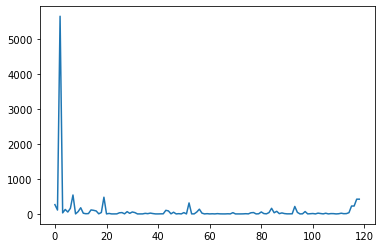

In [24]:
plt.plot(f_regression(X_ridge_rfe, y)[0])
plt.show()

In [30]:
df_perc_ridge = pd.DataFrame(columns = ["p"] + LISTE_COL )

for p in range(0, 101) :
    
    selector = SelectPercentile(f_regression, p)
    X_ridge_perc = selector.fit_transform(X_ridge_rfe, y)
    df_perc_ridge = df_perc_ridge.append(dict({"p" : p}, **modelize(Ridge(), "Ridge", X_ridge_perc, y)), ignore_index = True)
    
df_perc_ridge.sort_values("RMSLE")[:5]

,p,Model,Fit_Time,Score_time,MAE,RMSLE,R2
77,77,Ridge,0.046002,0.006001,0.370575,0.034561,0.716380
81,81,Ridge,0.045003,0.005001,0.370495,0.034563,0.716363
76,76,Ridge,0.047002,0.005001,0.370488,0.034564,0.716386
80,80,Ridge,0.047002,0.005001,0.370456,0.034565,0.716351
78,78,Ridge,0.048003,0.005000,0.370551,0.034568,0.716280


In [31]:
X_ridge_perc = SelectPercentile(f_regression, 77).fit_transform(X_ridge_rfe, y)
X_ridge_perc.shape

(3303, 91)

**SVR**

In [33]:
df_perc_svr = pd.DataFrame(columns = ["p"] + LISTE_COL)

for p in range(50, 101) :
    
    selector = SelectPercentile(f_regression, p)
    X_svr_perc = selector.fit_transform(X_svr_rfe, y)
    df_perc_svr = df_perc_svr.append(dict({"p" : p}, **modelize(SVR(), "SVR", X_svr_perc, y)), 
                                     ignore_index = True)
    
df_perc_svr.sort_values("RMSLE")[:5]

,p,Model,Fit_Time,Score_time,MAE,RMSLE,R2
50,100,SVR,1.690097,0.258014,0.365392,0.035474,0.702793
46,96,SVR,1.681094,0.261015,0.366461,0.035503,0.702611
47,97,SVR,1.680096,0.260015,0.366508,0.035506,0.702570
45,95,SVR,1.665095,0.260015,0.366621,0.035512,0.702439
44,94,SVR,1.706098,0.259015,0.366621,0.035513,0.702411


Pas d'améliorations

In [34]:
X_svr_perc = X_svr_rfe

**GB**

In [37]:
df_perc_GB = pd.DataFrame(columns = ["p"] + LISTE_COL)

for p in range(50, 101) :
    
    selector = SelectPercentile(f_regression, p)
    X_gb_perc = selector.fit_transform(X_gb_rfe, y)
    df_perc_GB = df_perc_GB.append(dict({"p" : p}, **modelize(liste_estimator[2], "GB", X_gb_perc, y)), 
                                   ignore_index = True)
    
df_perc_GB.sort_values("RMSLE")[:5]

,p,Model,Fit_Time,Score_time,MAE,RMSLE,R2
41,91,GB,1.587091,0.012000,0.379796,0.035469,0.699677
40,90,GB,1.604091,0.014001,0.380028,0.035475,0.699687
47,97,GB,1.628093,0.014001,0.380278,0.035478,0.700070
46,96,GB,1.667095,0.014000,0.380543,0.035491,0.699924
45,95,GB,1.601092,0.013001,0.380541,0.035514,0.699470


In [41]:
X_gb_perc = SelectPercentile(f_regression, 91).fit_transform(X_gb_rfe, y)

**XGB**

In [44]:
df_perc_XGB = pd.DataFrame(columns = ["p"] + LISTE_COL)

for p in range(50, 101) :
    
    selector = SelectPercentile(f_regression, p)
    X_xgb_perc = selector.fit_transform(X_xgb_rfe, y)
    df_perc_XGB = df_perc_XGB.append(dict({"p" : p}, **modelize(liste_estimator[3], "XGB", X_xgb_perc, y)), 
                                     ignore_index = True)
    
df_perc_XGB.sort_values("RMSLE")[:5]

,p,Model,Fit_Time,Score_time,MAE,RMSLE,R2
39,89,XGB,0.638036,0.048003,0.388674,0.036325,0.687307
38,88,XGB,0.760043,0.049003,0.387799,0.036380,0.686504
41,91,XGB,0.648037,0.047003,0.389246,0.036410,0.686330
35,85,XGB,2.250129,0.047003,0.389759,0.036530,0.682563
33,83,XGB,1.357078,0.058003,0.389622,0.036539,0.682785


In [45]:
X_xgb_perc = SelectPercentile(f_regression, 89).fit_transform(X_xgb_rfe, y)
X_xgb_perc.shape

(3303, 151)

In [57]:
liste_X_perc = [X_ridge_perc, X_svr_perc, X_gb_perc, X_xgb_perc]

In [58]:
pickle_out = open("Data/liste_X_perc.pickle", "wb")
pickle.dump(liste_X_perc, pickle_out)
pickle_out.close()

# GRIDSEARCH

In [12]:
liste_X_gs = pickle.load(open("Data/liste_X_perc.pickle", "rb"))

X_ridge_gs = liste_X_gs[0]
X_svr_gs = liste_X_gs[1]
X_gb_gs = liste_X_gs[2]
X_xgb_gs = liste_X_gs[3]

## Ridge

In [61]:
param_ridge = {"alpha" : np.logspace(0.001, 1, 50)}
ridge_grid = GridSearchCV(Ridge(), param_ridge, scoring = "neg_mean_squared_log_error")
ridge_grid.fit(X_ridge_gs, y)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([ 1.00230524,  1.05047992,  1.10097006,  1.15388696,  1.20934725,
        1.26747317,  1.32839285,  1.39224057,  1.45915706,  1.52928981,
        1.60279342,  1.6798299 ,  1.76056904,  1.84518883,  1.93387577,
        2.02682535,  2.12424244,  2.22634178,  2.33334841,  2.4454982 ,
        2.56303834,  2.68622791,  2.81533845,  2.95065455,  3.09247447,
        3.2411108 ,  3.39689117,  3.56015895,  3.73127401,  3.91061352,
        4.0985728 ,  4.29556612,  4.5020277 ,  4.71841264,  4.94519787,
        5.18288328,  5.43199278,  5.69307544,  5.96670675,  6.25348985,
        6.55405685,  6.86907027,  7.19922446,  7.54524714,  7.90790101,
        8.28798544,  8.6863382 ,  9.10383735,  9.54140312, 10.        ])},
             scoring='neg_mean_squared_log_error')

In [62]:
ridge_grid.best_params_

{'alpha': 1.0504799196403356}

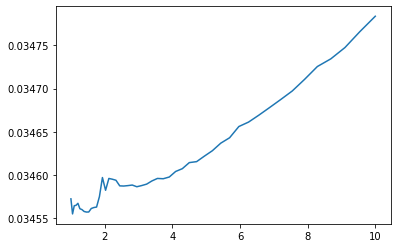

In [63]:
score = np.sqrt(- ridge_grid.cv_results_["mean_test_score"])
plt.plot(np.logspace(0.001, 1, 50), score)

In [63]:
np.sqrt(-max(ridge_grid.cv_results_["mean_test_score"]))

0.034555121320351205

In [64]:
best_ridge = ridge_grid.best_estimator_
modelize(best_ridge, "best_ridge", X_ridge_gs, y)

{'Model': 'best_ridge',
 'Fit_Time': 0.05600285530090332,
 'Score_time': 0.007000446319580078,
 'MAE': 0.37042619270802196,
 'RMSLE': 0.034555121320351205,
 'R2': 0.7164971789476553}

## Ridge sans outlier

In [44]:
scr = SVR()

## SVR

In [45]:
# param_SVR = {"kernel" : ["rbf"], 
#              "gamma" : ["scale"], 
#              "C" : [0.1, 1, 10, 20, 100, 500, 1000, 10000],
#              "epsilon" : [0.1, 0.5, 1]
#             }

svr_grid = GridSearchCV(SVR(), 
                        param_SVR, 
                        scoring = "neg_mean_absolute_error", 
                        cv = K)

In [46]:
start = time()
svr_grid.fit(X_svr_gs, y)
print(time()-start)

643.9958343505859


In [50]:
svr = svr_grid.best_estimator_
svr_grid.best_params_

{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

In [51]:
modelize(svr, "best_svr", X_svr_gs, y)

{'Model': 'best_svr',
 'Fit_Time': 1.909109354019165,
 'Score_time': 0.2930166721343994,
 'MAE': 0.3653921377522994,
 'RMSLE': 0.035473732504030756,
 'R2': 0.7027934126499905}

In [52]:
param_SVR2 = {"kernel" : ["rbf"], 
             "gamma" : ["scale"], 
             "C" : [0.5, 1, 1.5],
             "epsilon" : [0.01, 0.05, 0.1, 0.15]
            }

svr_grid2 = GridSearchCV(SVR(), 
                        param_SVR2, 
                        scoring = "neg_mean_absolute_error", 
                        cv = K)

In [53]:
start = time()
svr_grid2.fit(X_svr_gs, y)
print(time()-start)

28.099607229232788


In [54]:
svr2 = svr_grid2.best_estimator_
svr_grid2.best_params_

{'C': 1.5, 'epsilon': 0.15, 'gamma': 'scale', 'kernel': 'rbf'}

In [55]:
modelize(svr2, "best_svr", X_svr_gs, y)

{'Model': 'best_svr',
 'Fit_Time': 1.6160919666290283,
 'Score_time': 0.23301386833190918,
 'MAE': 0.36352157146239256,
 'RMSLE': 0.035316657369804966,
 'R2': 0.7049858002235844}

In [104]:
param_SVR = {"kernel" : ["rbf"], 
             "gamma" : ["auto"], 
             "C" : np.linspace(19, 19.9, 10)
            }
svr_grid2 = GridSearchCV(SVR(), 
                         param_SVR, 
                         #scoring = "neg_mean_absolute_error", 
                         scoring = "neg_mean_squared_log_error",
                         cv = K)

In [106]:
svr2 = svr_grid2.best_estimator_
svr_grid2.best_params_

{'svr__C': 19.9, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}

In [107]:
modelize(svr2, "best_svr", X, y)

{'Model': 'best_svr',
 'Fit_Time': 2.851162910461426,
 'Score_time': 0.4410250186920166,
 'MAE': 0.35803071855458646,
 'RMSLE': 0.034331112323723455,
 'R2': 0.720587650981068}

## SVR OL

In [112]:
# param_SVR_2 = {"svr__kernel" : ["rbf"], 
#              "svr__gamma" : ["auto"], 
#              "svr__C" : np.linspace(1, 50, 10)
#             }

param_SVR_2 = {"svr__kernel" : ["rbf"], 
             "svr__gamma" : ["auto"], 
             "svr__C" : np.linspace(10.7, 12, 14)
            }


svr_grid_ol = GridSearchCV(svr_ol,
                           param_SVR_2,
                           scoring = "neg_mean_squared_log_error",
                           cv = K)

start = time()
svr_grid_ol.fit(X_svr, y)
print(time()-start)

42.28541851043701


In [113]:
best_svr_ol = svr_grid_ol.best_estimator_
svr_grid_ol.best_params_

{'svr__C': 11.2, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}

In [114]:
modelize(best_svr_ol, "best_svr_ol", X_svr, y)

{'Model': 'best_svr_ol',
 'Fit_Time': 2.522143840789795,
 'Score_time': 0.3930225372314453,
 'MAE': 0.3594669325919394,
 'RMSLE': 0.0343791543671741,
 'R2': 0.7203569228913068}

## XGB

In [34]:
xgb = xgboost.XGBRegressor(random_state = SEED)

In [35]:
param_XGB = {"max_depth" : [2, 3, 4, 5],
             "subsample" : np.linspace(0.8, 1, 10),
             "n_estimators" : [100, 250, 500, 1000, 5000],
             "objective" : ["reg:squaredlogerror"],
             "eta" : np.linspace(0.01, 2, 10),
             #"booster" : ["gbtree", "gblinear", "dart"]
            }


xgb_grid = GridSearchCV(xgb,
                        param_XGB,
                        scoring = "neg_mean_squared_log_error",
                        cv = K)

In [36]:
start = time()
xgb_grid.fit(X_xgb_gs, y)
print(time()-start)

12323.758868455887


In [37]:
best_xgb = xgb_grid.best_estimator_
xgb_grid.best_params_

{'eta': 0.01,
 'max_depth': 4,
 'n_estimators': 5000,
 'objective': 'reg:squaredlogerror',
 'subsample': 1.0}

In [38]:
modelize(best_xgb, "rd_xgb", X_xgb_gs, y)

{'Model': 'rd_xgb',
 'Fit_Time': 17.771016359329224,
 'Score_time': 0.12100672721862793,
 'MAE': 0.44304831249852583,
 'RMSLE': 0.04103796308980768,
 'R2': 0.5970578714138849}

0       15.033291
1       14.130245
2       16.133554
3       15.693689
4       16.616685
          ...    
3335    14.082119
3336    14.367457
3337    16.550148
3338    13.627239
3339    13.840094
Name: SiteEnergyUseWN(kBtu), Length: 3303, dtype: float64

In [31]:
param_XGB = {"max_depth" : [2, 3, 4, 5],
             "subsample" : np.linspace(0.8, 1, 10),
             "n_estimators" : [100, 250, 500, 1000, 5000],
             "objective" : ["reg:squaredlogerror"],
             "eta" : np.linspace(0.01, 2, 10),
            }


xgb_rd = RandomizedSearchCV(xgb,
                            param_XGB,
                            n_iter = 200,
                            scoring = "neg_mean_squared_log_error",
                            cv = K)

In [32]:
# 200 model
start = time()
xgb_rd.fit(X_xgb_gs, y)
print(time()-start)

[22:12:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:12:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:12:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth, subsample } might not be used.

  This may not be accurate due to some parame

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [33]:
rd_xgb = xgb_rd.best_estimator_
xgb_rd.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [ ]:
modelize(rd_xgb, "rd_xgb", X_xgb_gs, y)

# randomizedSearch

In [172]:
param_XGB = {#"xgbregressor__booster" : ["gblinear"],
             "xgbregressor__max_depth" : [2, 3, 4, 5],
             "xgbregressor__subsample" : [0.97, 0.98, 0.99, 1],
             "xgbregressor__n_estimators" : [500, 600, 700, 800, 900, 1000, 1100, 1200, 1500],
             "xgbregressor__objective" : ["reg:squaredlogerror"],
             "xgbregressor__eta" : np.linspace(0.01, 0.3, 10),
             "xgbregressor__min_child_weight" : [0, 1, 2, 3, 4]#,
             #"xgbregressor__colsample_bytree" : [0.5, 0.75, 1],
             #"xgbregressor__colsample_bylevel" : [0.5, 0.75, 1]
            }


xgb_rd = RandomizedSearchCV(xgb_reg,
                              param_XGB,
                              n_iter = 200,
                              scoring = "neg_mean_squared_log_error",
                              cv = K)

In [173]:
# 200 model
start = time()
xgb_rd.fit(X, y)
print(time()-start)

912.5611956119537


In [174]:
rd_xgb = xgb_rd.best_estimator_
xgb_rd.best_params_

{'xgbregressor__subsample': 0.97,
 'xgbregressor__objective': 'reg:squaredlogerror',
 'xgbregressor__n_estimators': 1100,
 'xgbregressor__min_child_weight': 0,
 'xgbregressor__max_depth': 2,
 'xgbregressor__eta': 0.1711111111111111}

In [175]:
modelize(rd_xgb, "rd_xgb", X, y)

{'Model': 'rd_xgb',
 'Fit_Time': 4.197240114212036,
 'Score_time': 0.1150064468383789,
 'MAE': 0.38372759379794297,
 'RMSLE': 0.035563654995112284,
 'R2': 0.6986951046825929}

In [168]:
# 150 model
start = time()
xgb_rd.fit(X, y)
print(time()-start)

325.9426429271698


In [169]:
rd_xgb = xgb_rd.best_estimator_
xgb_rd.best_params_

{'xgbregressor__subsample': 0.98,
 'xgbregressor__objective': 'reg:squaredlogerror',
 'xgbregressor__n_estimators': 400,
 'xgbregressor__min_child_weight': 0,
 'xgbregressor__max_depth': 4,
 'xgbregressor__eta': 0.17421052631578948}

In [170]:
modelize(rd_xgb, "rd_xgb", X, y)

{'Model': 'rd_xgb',
 'Fit_Time': 2.258129358291626,
 'Score_time': 0.1150064468383789,
 'MAE': 0.3852200414916226,
 'RMSLE': 0.03594275721999567,
 'R2': 0.6934105895508806}

In [165]:
# 150 model
start = time()
xgb_rd.fit(X, y)
print(time()-start)

306.73154401779175


In [166]:
rd_xgb = xgb_rd.best_estimator_
xgb_rd.best_params_

{'xgbregressor__subsample': 0.96,
 'xgbregressor__objective': 'reg:squaredlogerror',
 'xgbregressor__n_estimators': 1000,
 'xgbregressor__min_child_weight': 0,
 'xgbregressor__max_depth': 2,
 'xgbregressor__eta': 0.1536842105263158}

In [167]:
modelize(rd_xgb, "rd_xgb", X, y)

{'Model': 'rd_xgb',
 'Fit_Time': 3.9792282581329346,
 'Score_time': 0.12000632286071777,
 'MAE': 0.38512171154494157,
 'RMSLE': 0.03563583670388438,
 'R2': 0.6969720200069192}

# Learning Curve

In [176]:
mod_lc = [best_ridge, svr2, rd_xgb]

In [ ]:
fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")

In [198]:
lc_ridge = learning_curve(best_ridge, X, y ,train_sizes = np.linspace(0.05, 1, 20))

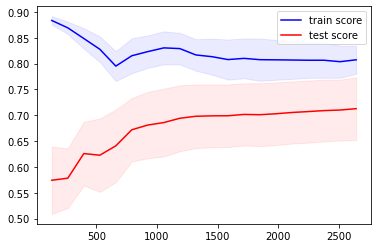

In [207]:
train_scores = lc_ridge[1].mean(axis = 1)
train_std = lc_ridge[1].std(axis = 1)
test_scores = lc_ridge[2].mean(axis = 1)
test_std = lc_ridge[2].std(axis = 1)


plt.plot(lc_ridge[0], train_scores, color='blue', label="train score")
plt.fill_between(lc_ridge[0], 
                 train_scores - train_std,
                 train_scores + train_std, alpha=0.08,
                 color="blue")

plt.plot(lc_ridge[0], test_scores, color='red', label="test score")
plt.fill_between(lc_ridge[0], 
                 test_scores - test_std,
                 test_scores + test_std, alpha=0.08,
                 color="red")
plt.legend()
plt.show()

In [200]:
lc_svr = learning_curve(svr2, X, y ,train_sizes = np.linspace(0.05, 1, 20))

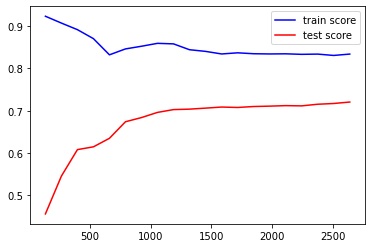

In [201]:
train_scores = lc_svr[1].mean(axis = 1)
test_scores = lc_svr[2].mean(axis = 1)

plt.plot(lc_svr[0], train_scores, color='blue', label="train score")
plt.plot(lc_svr[0], test_scores, color='red', label="test score")
plt.legend()
plt.show()

In [202]:
lc_xgb = learning_curve(rd_xgb, X, y ,train_sizes = np.linspace(0.05, 1, 20))

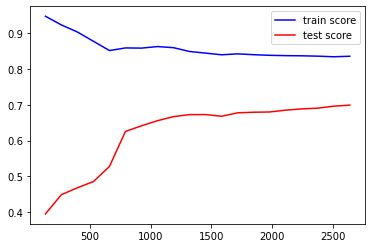

In [203]:
train_scores = lc_xgb[1].mean(axis = 1)
test_scores = lc_xgb[2].mean(axis = 1)

plt.plot(lc_xgb[0], train_scores, color='blue', label="train score")
plt.plot(lc_xgb[0], test_scores, color='red', label="test score")
plt.legend()
plt.show()